# CSE 7324 Lab Assignment Three: Extending Logistic Regression
Minging Li, Jiayin Liu, Tianlei Xu, He Zhou  
  Mar.04, 2018

# 1. Preparation and Overview

## 1.1 Business Understanding

The data used in this assignment represents a random sample of abalone from the Tasmanian Coastline, which was from a study initiated by the Tasmanian Aquaculture and Fisheries Institute. The goal of the study was to investigate the growth patterns of abalone living along the Tasmanian coastline. We obtained the dataset through UCI Machine Learning Repository (1). 

The classification task is to predict the rings (an indicator of age, rings + 1.5 gives the age in years) of abalone from various physical measurements. In this study, rings are treated as a 3-category classification problem (grouping rings classes 1-8, 9-12, and 13 on). Rings numbered 1-8 usually represent to infant abalone. Traditionally, the age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope, which is a boring and time-consuming task. If other measurements, such as weight, height and length, which are easier to obtain, can be used to predict the age, the estimation of abalone ages would be a much easier task. Additional, the harvest of abalone is restricted by both the number and size limit of abalone that can be caught. The restriction is an effective way to control the population of abalone. An accurate model could provide a simple way to tell the age of abalone based on their various measurements. This would be helpful for Tasmanian officials to develop rules on the size of abalone harvest. 

## 1.2 Data Understanding and Pre-processing

First, we import the dataset into Python.

In [1]:
# load data  
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel('/Users/jiayinliu/Desktop/study/ML/proj3/Abalone.xlsx')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


The dataset contains 9 variables and 4177 instances. The variable Sex is catagorical and other variables are numerical. 

We need to check if there are missing values.

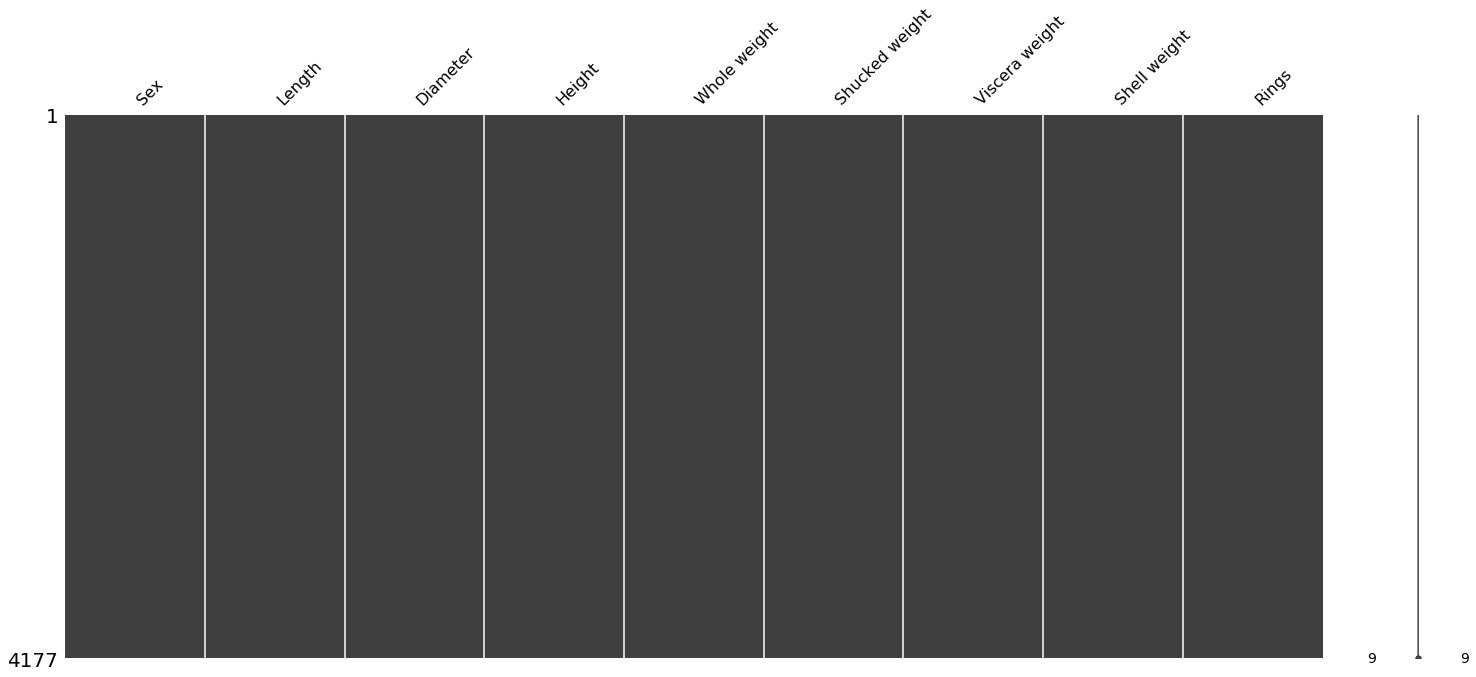

In [2]:
import missingno as mn
import matplotlib.pyplot as plt
mn.matrix(df.sort_values(by=["Rings"]))
plt.show()

We can see from the graph that there are no missing values.

We investigate the correlations among these variables.

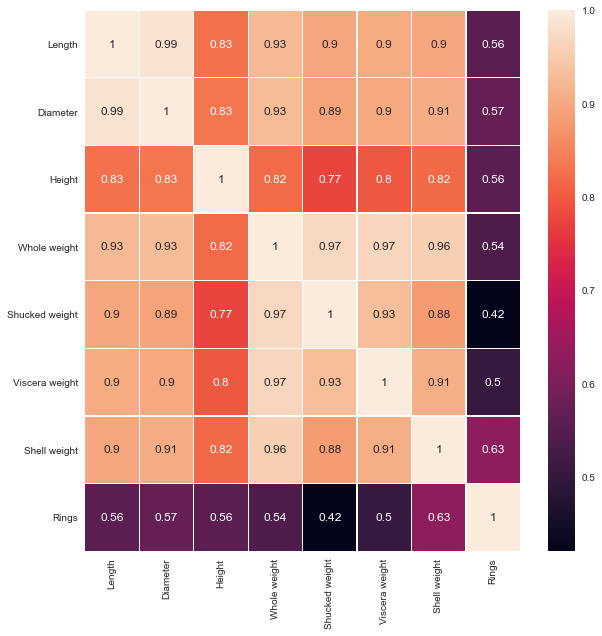

In [4]:
# show the relationship between attributes 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
graph, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), annot=True,linewidths=0.3)
graph.tight_layout()
plt.show()

The above heatmap shows the correlation coefficient between each of the numerical variables. We can see that the correlation coefficient between all other attributes except "Shucked weight" and "Rings" are higher than 0.5. "Shucked weight" and "Rings" have the lowest correlation coefficient of 0.42. To be conservative on our prection model, we keep all the 7 variables as predictors. 

We also want to investigate the relationship between the categorical variable "Sex" and "Rings".

In [ ]:
ax=sns.boxplot(x="Sex", y="Rings", data=df)
plt.show()

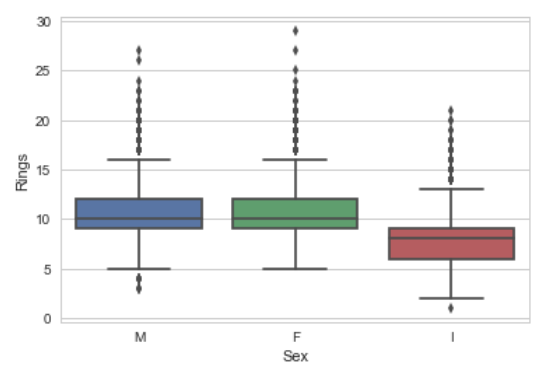

We create boxplots of "Rings" as a function of "Sex". The distributions of infant differ from the distribution of male and female. However, the distributions of male and female are almost the same. Sex is not directly related to number of rings. Thus we decide to delete the variable "Sex" to improve prediction accuracy. 

In [3]:
#The sex has little connection to our result,so we delete it to improve the accurancy.
del df['Sex']

We treat "Rings" as a 3-category classification problem (grouping rings classes 1-8, 9-12, and 13 on). Rings numbered 1-8 usually represent to infant abalone.

In [5]:
#convert the rings to numrical indicator
df['Rings'] = pd.cut(df['Rings'],[0,8,12,1e6],
                                 labels=['1-8','9-12','13+']) # this creates a new variable
df.Rings.value_counts()

9-12    2077
1-8     1407
13+      693
Name: Rings, dtype: int64

Based on their rings(rings reprensent their ages),we want to classify the Abalone to three categories:Infant, youth, and adult. We use 0,1,2 to represent the classfication, 0 means infant, 1 means youth, 2 means adult.

In [6]:
df.Rings.replace(to_replace = ['1-8','9-12', '13+'],
                 value = range(3), inplace = True)


In [7]:
df

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,2
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0
5,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.1200,0
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.3300,2
7,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.2600,2
8,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.1650,1
9,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.3200,2


### New Dataset Description

The new dataset contains 1 responsible variable "Rings". The type of "Rings" is nominal and the values are 0, 1, 2. The 7 explanatory variables are "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", and "Shell weight", the range of which are 0.075-0.815mm, 0.055-0.65mm, 0-1.13mm, 0.002-2.825g, 0.001-1.488g, 0.005-0.76g, and 0.0015-1.005g, respectively. All of the explanatory variables are numerical. The final dataset contains 4177 instances. 

## 1.3 data spilt

Use the cross validation modules to spilt data,80% for training set, 20% for testing set.

In [8]:
from sklearn.cross_validation import train_test_split
train_size = 0.80
test_size = 1 - train_size
train, test = train_test_split(df, train_size=train_size)
print('Compare Data Set Size')
print('==========================')
print('Original Dataset size: {}'.format(df.shape))
print('Train size: {}'.format(train.shape))
print('Test size: {}'.format(test.shape))

Compare Data Set Size
Original Dataset size: (4177, 8)
Train size: (3341, 8)
Test size: (836, 8)


/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
X = df
y =df['Rings']
del X['Rings']
y_train = train['Rings']
X_train = train
X_test = test
y_test = test['Rings']
del X_train['Rings']
del X_test['Rings']

## 1.4 Dimensionality Reduction using PCA

In [10]:
%%time
from sklearn.metrics import accuracy_score
import psutil
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression() # all params default
lr_sk.fit(X,y)
lr_mem = psutil.virtual_memory()
print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))
print('Used RAM memory: ', round(lr_mem.used/(1024**3), 2), 'GB')

[[  3.48246568  -1.14024392  -2.39842383  -1.926254    -4.07488866
    6.57459129  -1.42344502  -6.74152536]
 [ -4.31738194   5.30156027   4.30888646   0.8083081   -2.37859413
    4.68124389   2.53425915  -2.22094073]
 [ -3.43320961  -0.75534739   1.20813682   2.38917416   4.08896312
  -10.47257205  -0.92232864   6.89780037]]
Accuracy of:  0.689011252095
Used RAM memory:  6.14 GB
CPU times: user 79.5 ms, sys: 21.1 ms, total: 101 ms
Wall time: 124 ms


Here we try scikit-learn to check if our data is appropriate. We can see that the accuracy is about 68%, which is a little low. So we try extra steps to process our data to get higher accuracy.

In [11]:
# dimensionality reduction
from sklearn.svm import LinearSVC
from sklearn.decomposition import RandomizedPCA

n_components = 4
pca = RandomizedPCA(n_components=n_components)
X = pca.fit_transform(X)

clf = LinearSVC()
clf.fit(X,y)

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

We choose RandomizedPCA for dimensionality reduction. We set n_components equals to 7,6,5,4, and then we find when n_components = 4, we can get the better accuracy. We think in this situation, the linear logistic regression is fit.

In [12]:
#final dataset
X

array([[-0.37297053,  0.00140299, -0.01135034,  0.00844962],
       [-0.72693017,  0.02987049,  0.03463277,  0.00153644],
       [-0.17700541, -0.05958994, -0.03216066, -0.00228418],
       ..., 
       [ 0.41895149,  0.01668526, -0.01313201, -0.03242656],
       [ 0.34791783,  0.02404874, -0.06146214, -0.00716533],
       [ 1.31843776,  0.13799284,  0.03434871,  0.04449148]])

## 80/20 split appropriate or not?  

Our dataset contains 4177 instances,when we use 80/20 split,our train siz is 3341 and our test size is 836.Totally we have 7 features. So the train size and the test size are large enough to train and test.
Furthermore,The Pareto principle (also known as the 80/20 rule, the law of the vital few, or the principle of factor sparsity)states that, for many events, roughly 80% of the effects come from 20% of the causes(2).

# 2. Modeling 

## 2.1 Multinomial Logistic Regression

In [13]:
from sklearn.metrics import accuracy_score
from scipy.special import expit
from scipy.optimize import fmin_bfgs
from ipywidgets import widgets as wd
from sklearn import metrics as mt
from numpy.linalg import pinv

In [14]:
# define binary logistic:
class BinaryLogisticRegression:
    def __init__(self, eta, method, iterations, C,norm):  # default  and non default location
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.method = method
        self.norm = norm
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    
    @staticmethod
    def cost_function(w,X,y,C,reg):
        g = expit(X @ w)
        ydiff = y-g
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if norm == 'L1':
            reg = C*sum(abs(w))
        if norm == 'L2':
            reg = C*sum(w**2)
        if norm == 'L1+L2':
            reg = C*sum(abs(w))+ C*sum(w**2)
        if norm == ' ':
            reg = 0
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + reg
            
    def _get_gradient(self,X,y):   # using matrix 
        if self.method == 'steepest':
            ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C
            
            #return gradient
        
        if self.method == 'stochastic':
            idx = int(np.random.rand()*len(y)) # grab random instance
            ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
            gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through

            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C
            
        if self.method == 'Hession':
            g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
            hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

            ydiff = y-g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C

            return pinv(hessian) @ gradient
        
        
        if self.norm == 'L1':
            gradient[1:] += -abs(self.w_[1:]) * self.C
        if self.norm == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        if self.norm == 'L1+ L2':
            gradient[1:] += -2 * self.w_[1:] * self.C-self.w_[1:]/abs(self.w_[1:]) * self.C
        if self.norm == ' ':
            gradient[1:] += 0
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        for m in range(int(self.iters)):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate

In [15]:
# define multi-classifier
class LogisticRegression:
    def __init__(self, eta, C, method,iterations,norm):
        self.eta = eta
        self.iterations = iterations
        self.C = C
        self.method = method
        self.norm=norm
        
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value   
            y_binary = y==yval
            #y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = BinaryLogisticRegression(eta = self.eta,iterations = self.iterations,C = self.C,method = self.method,norm=self.norm)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

## 2.2 Data Training

Here we start to make some adjustments to the methods.We foucs on different optimization technique, and change the value of the regularization term "C" to achieve the best result. We set the eta as 0.1 and iteration as 1000 as default. The result of 'steepest' and 'stochnastic' are related to 'C', so we change the value of it and make graph to represent the change. While 'Hession' has no relation with the 'C', and its running time is large, so here we just run it for one time. From the test value, when we use 'L1+L2' would get the best result. So we apply it for each method.

### 2.2.1 Steepest

In [16]:
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt

In [17]:
best_accuracy_ste =0
acc_ste=[]
start_time = time.time()
for cost in np.arange(0,0.03,0.001):
    lr = LogisticRegression(eta = 0.1,iterations = 1000,C = cost, method = 'steepest',norm='L1+L2')
    lr.fit(X_train,y_train)
    yhat = lr.predict(X_test)
    acc_ste.append(accuracy_score(y_test,yhat))
    if(accuracy_score(y_test,yhat)>best_accuracy_ste):
        best_accuracy_ste = accuracy_score(y_test,yhat)
        best_C = cost
ste_mem = psutil.virtual_memory()
ste_time = (time.time() - start_time)/30
print('Accuracy: ',best_accuracy_ste)
print('Best C: ',best_C)
print('Running Time: %s milliseconds' % round(ste_time*1000, 2))
print('Used RAM memory: ', round(ste_mem.used/(1024**3), 2), 'GB')

Accuracy:  0.681818181818
Best C:  0.016
Running Time: 880.81 milliseconds
Used RAM memory:  6.15 GB


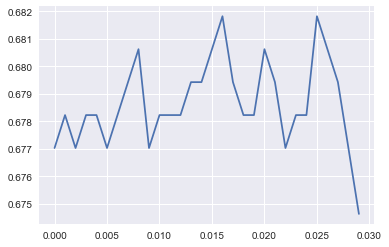

In [18]:
m = np.arange(0,0.03,0.001) 
plt.plot(m,acc_ste)
plt.savefig("easyplot.jpg") 
plt.show()

### 2.2.2 Stochastic

In [19]:
best_accuracy_sto =0
acc_sto=[]
X1=np.array(X_train)
y1=np.array(y_train)
X2=np.array(X_test)
y2=np.array(y_test)
start_time = time.time()
for cost in np.arange(0,0.03,0.001):
    lr = LogisticRegression(eta = 0.1,iterations = 1000,C = cost, method = 'stochastic',norm='L1+L2')
    lr.fit(X1,y1)
    yhat = lr.predict(X2)
    acc_sto.append(accuracy_score(y2,yhat))
    if(accuracy_score(y_test,yhat)>best_accuracy_sto):
        best_accuracy_sto = accuracy_score(y2,yhat)
        best_C = cost
sto_mem = psutil.virtual_memory()
sto_time = (time.time() - start_time)/30
print('Accuracy: ',best_accuracy_sto)  
print('Best C: ',best_C)
print('Running Time: %s milliseconds' % round(sto_time*1000, 2))
print('Used RAM memory: ', round(sto_mem.used/(1024**3), 2), 'GB')

Accuracy:  0.680622009569
Best C:  0.018
Running Time: 57.11 milliseconds
Used RAM memory:  6.16 GB


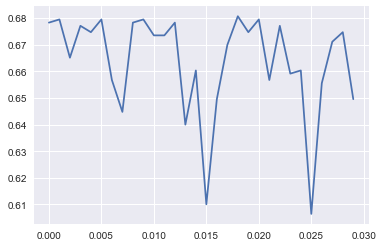

In [20]:
m = np.arange(0,0.03,0.001) 
plt.plot(m,acc_sto)  
plt.savefig("easyplot.jpg") 
plt.show()

### 2.2.3 Hession

In [21]:
start_time = time.time()
lr = LogisticRegression(eta = 0.1,iterations = 1000,C = 0.01, method = 'Hession',norm='L1+L2')
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
acc_Hes=(accuracy_score(y_test,yhat))
Hes_mem = psutil.virtual_memory()
Hes_time = (time.time() - start_time)
print('Accuracy: ',acc_Hes) 
print('Running Time: %s milliseconds' % round(Hes_time*1000, 2))
print('Used RAM memory: ', round(Hes_mem.used/(1024**3), 2), 'GB')

Accuracy:  0.733253588517
Running Time: 102684.5 milliseconds
Used RAM memory:  6.19 GB


Before the result showed above, we have tested various ranges of C, and this is the range which contributes to the best result of the accuracy. Also, the parameter C is just a small number to justify the cost function. So I think it is justified to select the parameters.

Data dredging (also data fishing, data snooping, and p-hacking) is the use of data mining to uncover patterns in data that can be presented as statistically significant, without first devising a specific hypothesis as to the underlying causality.In our dataset, if we don't add the regularization and apply the whole data into train set,then our accuracy will be above 90%. This result will be absolutly overfitting. After the correct operation of data dealing and add the both L1 and L2 regularization, our accuracy will decrease to 65%, thus how we overcome data snooping.

## 2.3 Performance comparison

### 2.3.1 Accuracies, Running Time, and Ram Usage from sklearn

In [22]:
from sklearn.linear_model import LogisticRegression
start_time = time.time()

acc = []
lr_sk = LogisticRegression(solver='lbfgs',n_jobs=1, class_weight=None) # all params default
# train object
lr_sk.fit(X_train,y_train)
# get test set predictions
y_hat = lr_sk.predict(X_test)

lr_sk_accuracy =  accuracy_score(y_test,yhat)
print('Accuracy: ', lr_sk_accuracy)
lr_sk_mem = psutil.virtual_memory()
lr_sk_time = (time.time() - start_time) #cell running time
print('Running Time: %s milliseconds' % round(lr_sk_time*1000, 2))
print('Used RAM memory: ', round(lr_sk_mem.used/(1024**3), 2), 'GB')

Accuracy:  0.733253588517
Running Time: 42.46 milliseconds
Used RAM memory:  6.2 GB


### 2.3.2 Comparison Visualization

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
com= pd.DataFrame
index = ['Steepest', 'Stochnastic', 'Hession', 'ScikitLearn']

columns = ['Method', 'Accuracy','Running Time', 'RAM Usage']
com = pd.DataFrame(columns=columns)
accuracy = (best_accuracy_ste, best_accuracy_sto, acc_Hes, lr_sk_accuracy)
running_time = (ste_time*1000, sto_time*1000, Hes_time*1000, lr_sk_time*1000)
ram_u = (ste_mem.used/(1024**3), sto_mem.used/(1024**3),Hes_mem.used/(1024**3), lr_sk_mem.used/(1024**3))
com['Method'] = index
com['Accuracy'] = np.array(accuracy)
com['Running Time'] = np.array(running_time)
com['RAM Usage'] = np.array(ram_u)
com

,Method,Accuracy,Running Time,RAM Usage
0,Steepest,0.681818,880.814830,6.152809
1,Stochnastic,0.680622,57.113393,6.158325
2,Hession,0.733254,102684.497118,6.194603
3,ScikitLearn,0.733254,42.458296,6.195496


The table shows the comparison between the Accuracy, Running time and RAM Usage of different methods.  The hession and ScikitLearn methods have better accuracy than Steepest and Stochnastic methods. Scikit Learn method is the fastest. The running time of Stochnastic is also good. The steepest method is a slower than Stochnastic. The running time of Hession is thousands  times of the ScikitLearn method. The RAM Usages for the four methods are all around 6.20. 
  Next, we will provide visualization of these methods. 

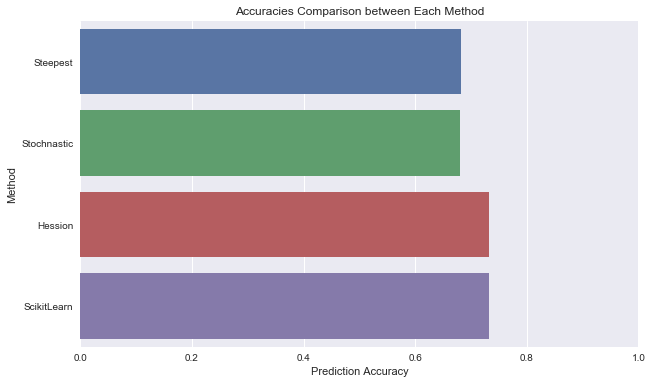

In [24]:
f, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(x="Accuracy", y='Method', data=com)
ax.set(xlim=(0, 1),
       xlabel="Prediction Accuracy")
plt.title('Accuracies Comparison between Each Method')
plt.show()

The Hession and ScikitLearn methods have better accuracy than Steepest and Stochnastic methods. The accuracy of between 0.7 and 0.8 (Hession and ScikitLearn) is usually considered as good while the accuracy of between 0.6 and 0.7 (Steepest and Stochnastic) is usually considered as poor. The is no difference in accuracy between Hession and ScikitLearn methods. 

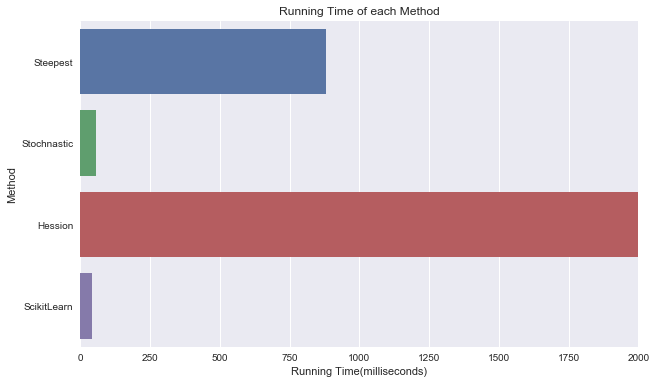

In [25]:
f, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(x="Running Time", y='Method', data=com)
ax.set(xlim=(0, 2000),
       xlabel="Running Time(milliseconds)")
plt.title('Running Time of each Method')
plt.show()

Scikit Learn method is the fastest. The running time of Stochnastic is also good. The steepest method is slower than Stochnastic. The running time of Hession is extremly long compared to the other three methods. 

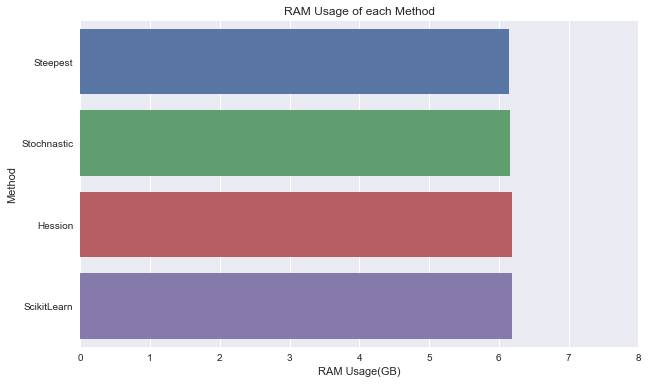

In [26]:
f, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(x='RAM Usage', y='Method', data=com)
ax.set(xlim=(0, 8),
       xlabel='RAM Usage(GB)')
plt.title('RAM Usage of each Method')
plt.show()

There is no difference in the RAM Usages among the four methods.

# 3. Deployment

Generally spesking, each method has its advantages and disadvantages. 

Steepest method is easy to implement. But it is usually associated with local optima problem. It is relatively slow when close to minimum, thus requires a  large numer of iterations. Overfitting is another problem when there are many parameters. Regulization, such as L1 and L2, can be used to prevent overfitting when applying steepest method. 

Stochastic Gradient Descent method computes gradient from just one sample and update. SGD is computationally fast and is good, which is good for large data set. Optimization can be achieved through only a portion of samples when the sample size is large (e.g.100,000). SGD pays a small penalty of accuracy and increased iterations. The final solution is close to the global optima.

Newton's method has the advantage of auqdratic convergence: the error is squared at each iteration (the number of accurate digits doubles). The disadvantage of Newton's method is that it requires calculating the derivative. In many cases, the function is given by a complex formula and an analytical expression for the derivative may not be easy to calculate. If the function is not continuously differentiable in a neighborhood of the root, it is possible that Newton's method will always diverge or fail. Newton's method will fail in cases where the derivative is zero (3). 

We would recommend to use ScikitLearn for the deployed machine learning model. From the implementaion of different methods for our dataset, we found that the Scikit-learn provided the highest accuracy and shortest running time.  

The implemetation of Scikit learn Parallelization is very fast. It is better handled through sklearn, separating out each classification, and the operations are ALL in lower level c++. The main reason, however, is that the update used is more advanced than what we have talked about. They have an array of solvers that use the gradient (and Hessian) to solve the optimization more quickly. The accuracy is higher because this logistic regression object uses regularization, which helps control for over-learning, and also because the optimization allows for finer steps when we get to places where the gradient is small and the objective function is less well behaved.

Stochastic Gradient Descent method or Scikit learn are good for large data set. Furthermore, Conjugate Gradients is also a good choice. It is fast. It doesn't require twice-differentiable function to find the roots of the derivative as Newton Method. It relatively requires less RAM, stable. For small dataset, All of the several methods mentioned above can be used for small data set. 

# 4. Exceptional Work 

If we use mean square error as objective function, the objective function may become to non-convex function.
Non-convex function can result in local optimal value. 

In [ ]:
class BinaryLogisticRegressionBase:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference ydiff
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)   
        gradient[1:] += -2 * self.w_[1:] * self.C    # updata gradient
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):  # function to check accuracy, working with following function
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):                     # function to check accuracy, working with above function
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)   # return gradient
            self.w_ += gradient*self.eta # multiply by learning rate   iteration 
                                         # shows convergence


Use mean square error to replace the binary entropy
Replace the cost function -np.sum(y*np.log(g)+(1-y)*np.log(1-g)) by np.sum((g-y)^2+C*np.sum(w^2) 

If we want to get the optimal result in one gradient update, we need to use Newton method.
As the cost function is non-convex function, we implement Quasi-Newton method.

In [ ]:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegressionBase):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return np.sum((g-y)**2) + C*np.sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

Apply the method to MultiClassification

In [ ]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

In [ ]:
lr = MultiClassLogisticRegression(_,iterations=1,C=0.00001)
lr.fit(X,y)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

As the result above, the accurancy is 82.7% in 1 iteration.
If we increase the iteration steps to 8, the accuracy can be 99%

In [ ]:
lr = MultiClassLogisticRegression(_,iterations=8,C=0.00001)
lr.fit(X,y)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

# Reference

1.	https://archive.ics.uci.edu/ml/datasets/abalone
2.	https://en.wikipedia.org/wiki/Pareto_principle
3.	http://www.cas.mcmaster.ca/~cs4te3/notes/newtons_method.pdf